## Python statistics essential training - 05_05_LogisticRegression

How Do we do model fitting when the response variables are categorical?

Standard imports

In [1]:
import math

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
import matplotlib.pyplot as pp

In [4]:
%matplotlib inline

In [5]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# fix error in some versions of statsmodels
import scipy
if not hasattr(scipy.stats,'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [6]:
smoking = pd.read_csv("whickham.csv")

In [10]:
# Remove all smokers over age 65 since none are alive after 20yrs
smoking = smoking[smoking.age < 65]

In [12]:
smoking.head()

,outcome,smoker,age
0,Alive,Yes,23
1,Alive,Yes,18
4,Alive,No,64
5,Alive,Yes,38
6,Alive,Yes,45


In [11]:
# Func to plot the data and the fit proedictions
color = np.where(smoking.smoker == 'No','skyblue','coral')
jitter = 0.05*(np.random.rand(len(smoking)) - 0.5)
def plotfit(fit):
    pp.scatter(smoking.age,smoking.outcome + jitter,c=color,linewidth=0.2,edgecolor='k',alpha=0.5)
    pp.scatter(smoking.age,fit.predict(smoking),c=color,linewidth=0.2,edgecolor='gray',marker='d')

In [13]:
# Convert the smoking outcome into binary (1 or 0) so it becomes possible to compute Ordinary Least Squares
# Python Trick to covert to binary: multiplying a boolean by an integer returns an integer. So filter the dataframe so that True/False is returned & multiply by 1
smoking['outcome'] = 1*(smoking['outcome'] == 'Alive')

In [17]:
smoking.sample(5)

,outcome,smoker,age
458,1,Yes,34
807,1,No,20
58,1,Yes,36
338,0,Yes,51
146,1,No,33


In [18]:
# Fit a model that includes smaking status & age as main terms
ols_group_age = smf.ols('outcome ~ smoker + age',data=smoking).fit()

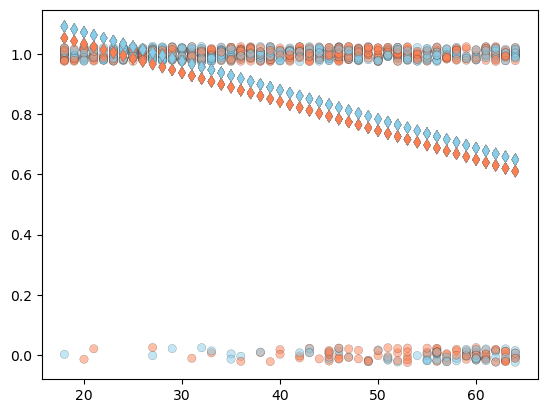

In [21]:
plotfit(ols_group_age) # The func written above
# Data plotted as circles
# Fit represented by diamonds
# Colors: Orange for smokers, blue for non-smokers
# jitter (move points randomly up & down) so they don't all lie on top of each other

In [20]:
ols_group_age.params

Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

In [22]:
sm.stats.anova_lm(ols_group_age)

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


In [24]:
# Confidence interval
# Rely on some mathmatical assumptions so take w/ grain of salt
ols_group_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


Plot shows a problem: some outcomes are large than 1 (should only be 1 or 0 for Alive or dead)

Choices: Limit the the output of the model to only 0 or 1

OR limit output to only values between 0 & 1 to show probability of one of the two outcomes

Done by constructing the model as before then applying a non-linear function to the output of the model

A usefull non-linear function is exponential logististic regression (.logit() in StatsModels)

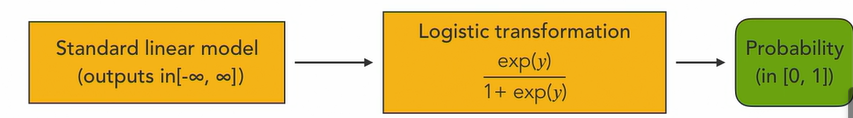

In [27]:
# Creating a new model using logit instead of OLS
logit_smoker_age = smf.logit('outcome ~ smoker + age',data=smoking).fit()

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7


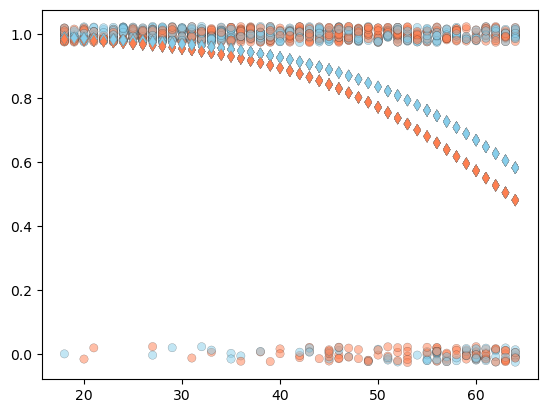

In [28]:
plotfit(logit_smoker_age)

THe model is now bounded by 0 & 1 AND also displays non-linear behavior even with only linear main terms

Criteria for goodness of fit for Logistic Regression is not minimizing the MSE of the residuals

Criteria for goodness of fit is interpreting the model response as a probabilit function and maximizing the resulting probability of the observed data.

This is a form of maximum-likelihood estimation.

Look at the value of the likelihood

In [33]:
# .llf to return the logarithm of the likelihood (from StatsModels)
logit_smoker_age.llf

-371.38650786619064

In [34]:
# The model params are not comparable to the least-squares params
logit_smoker_age.params

Intercept        6.250847
smoker[T.Yes]   -0.408103
age             -0.092403
dtype: float64

In [35]:
logit_smoker_age.conf_int()
# See that the association with smoking remains weak for the outcome

,0,1
Intercept,5.331126,7.170568
smoker[T.Yes],-0.777754,-0.038451
age,-0.109478,-0.075327


In [32]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                            2
Date:                Thu, 25 Apr 2024   Pseudo R-squ.:                  0.1776
Time:                        16:04:27   Log-Likelihood:                -371.39
converged:                       True   LL-Null:                       -451.59
Covariance Type:            nonrobust   LLR p-value:                 1.469e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2508      0.469     13.321      0.000       5.331       7.171
smoker[T.Yes]    -0.4081      0.189     -2.164      0.030      -0.778      -0.038
age              -0.0924      0.009    -10.606      0.000      -0.109      -0.075
=================================================================================
"""

Note that the logistic model probabilities are conditional probabilities. They depend on the value of explanatory variables and they refer directly to the cases in the data set, but not necessarily to the general population. Unless we can determine that the sample is truly representative of the population. 